# Feature Importance and Advanced Models

## Polynomial Regression

We are now extending the feature space to include quadratic and/or interaction terms to see if it improves the performance.

First, we load the dataset and initialize the KFold cross-validation.

In [65]:
import pandas as pd
from sklearn.model_selection import KFold

# Load the dataset
df = pd.read_pickle("../data/winequality.pkl")

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Then, we need to preprocess the data to include polynomial features. We can use `PolynomialFeatures` from `sklearn.preprocessing` for this purpose.

In [66]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df.drop(columns=["quality"]))
y = df["quality"]

Now, we initialize the linear regression model and perform the k-fold cross-validation to evaluate its performance.

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Initialize the model
lin_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])
# Store results
mse_list, rmse_list, r2_list = [], [], []

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X_poly[train_index], X_poly[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"Fold {fold+1}: R2 = {r2:.4f}, MSE = {mse:.4f}, RMSE = {rmse:.4f}")

# Aggregate results and save to CSV
results = pd.DataFrame({
    "Metric": ["MSE", "RMSE", "R2"],
    "Mean": [np.mean(mse_list), np.mean(rmse_list), np.mean(r2_list)],
    "Variance": [np.var(mse_list), np.var(rmse_list), np.var(r2_list)]
})
results.to_csv("../reports/tables/cross_validation_results.csv", index=False)

print("\nCross-validation results (aggregated):")
results

Fold 1: R2 = 0.2809, MSE = 0.4002, RMSE = 0.6326
Fold 2: R2 = 0.3375, MSE = 0.4879, RMSE = 0.6985
Fold 3: R2 = 0.3017, MSE = 0.4732, RMSE = 0.6879
Fold 4: R2 = 0.4021, MSE = 0.4081, RMSE = 0.6388
Fold 5: R2 = 0.1598, MSE = 0.4942, RMSE = 0.7030

Cross-validation results (aggregated):


,Metric,Mean,Variance
0,MSE,0.452719,0.001627
1,RMSE,0.672164,0.000914
2,R2,0.296402,0.006358


## Regularization



In [68]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd

# Features and target
X = df.drop(columns=["quality"])
y = df["quality"]

# Define cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X, y, cv):
    mse_scores = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")
    rmse_scores = np.sqrt(mse_scores)
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2")
    return {
        "MSE Mean": mse_scores.mean(),
        "MSE Var": mse_scores.var(),
        "RMSE Mean": rmse_scores.mean(),
        "RMSE Var": rmse_scores.var(),
        "R2 Mean": r2_scores.mean(),
        "R2 Var": r2_scores.var(),
    }

# Baseline linear regression
lin_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

ridge_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", Ridge(alpha=1.0, random_state=42))
])

lasso_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", Lasso(alpha=0.001, max_iter=10000, random_state=42))
])

results = {
    "Linear": evaluate_model(lin_reg, X, y, cv),
    "Ridge": evaluate_model(ridge_reg, X, y, cv),
    "Lasso": evaluate_model(lasso_reg, X, y, cv),
}

results_df = pd.DataFrame(results).T
results_df

,MSE Mean,MSE Var,RMSE Mean,RMSE Var,R2 Mean,R2 Var
Linear,0.416543,0.001513,0.644717,0.000883,0.356190,0.000727
Ridge,0.416507,0.001517,0.644687,0.000885,0.356257,0.000722
Lasso,0.416370,0.001528,0.644575,0.000893,0.356516,0.000691


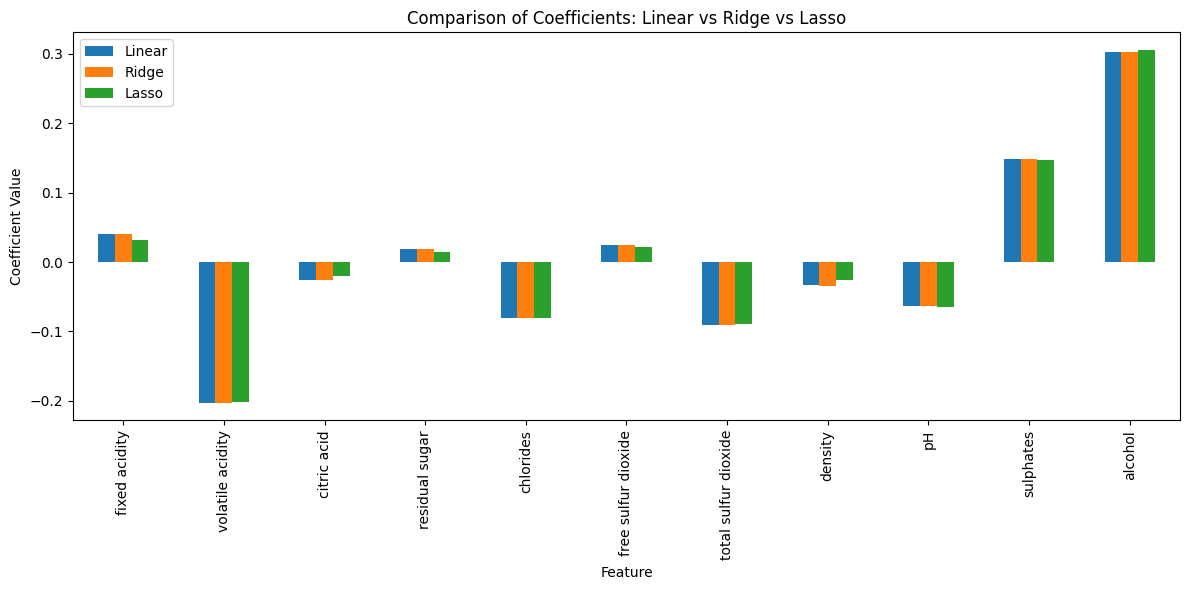

In [69]:
import matplotlib.pyplot as plt

# Fit models (with scaling)
lin_reg.fit(X, y)
ridge_reg.fit(X, y)
lasso_reg.fit(X, y)

# Extract coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Linear": lin_reg.named_steps["regressor"].coef_,
    "Ridge": ridge_reg.named_steps["regressor"].coef_,
    "Lasso": lasso_reg.named_steps["regressor"].coef_
})

# Plot coefficient comparison
coef_df.set_index("Feature").plot(kind="bar", figsize=(12, 6))
plt.ylabel("Coefficient Value")
plt.title("Comparison of Coefficients: Linear vs Ridge vs Lasso")
plt.tight_layout()
plt.savefig("../reports/figures/coef_comparison.png",
            bbox_inches="tight",
            dpi=300
            )
plt.show()

## A Non-Linear Model



In [70]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Define models with scaling
lin_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

tree_reg = Pipeline([
    ("scaler", StandardScaler()),  # scaling is not needed for trees, but included for consistency
    ("regressor", DecisionTreeRegressor(random_state=42))
])

rf_reg = Pipeline([
    ("scaler", StandardScaler()),  # scaling is not needed for forests, but included for consistency
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Evaluate models
results = {
    "Linear": evaluate_model(lin_reg, X, y, cv),
    "DecisionTree": evaluate_model(tree_reg, X, y, cv),
    "RandomForest": evaluate_model(rf_reg, X, y, cv),
}

results_df = pd.DataFrame(results).T
results_df

,MSE Mean,MSE Var,RMSE Mean,RMSE Var,R2 Mean,R2 Var
Linear,0.416543,0.001513,0.644717,0.000883,0.356190,0.000727
DecisionTree,0.636923,0.005696,0.796675,0.002232,0.009877,0.017368
RandomForest,0.353874,0.001722,0.593861,0.001204,0.454098,0.000891
